# Multi-Plant Tutorial 

For multi-plant workflows, images with multiple plants are processed and result in individual pictures for each plant, allowing a secondary workflow
(see [VIS tutorial](vis_tutorial.ipynb) for example) to be used.
The challenge of multi-plant processing is that a single plant can be composed of several contours, therefore contours need to be sorted and clustered together in some way.
There are several functions that help with multi-plant image processing. First, the current clustering functions work by asking the user to provide an approximation of the number of desired
'rows' and 'columns' that they would like to split the image into. There does not need to be a plant in each spot, but the grid is used as an approximate region to cluster contours within.
The [rotation](https://plantcv.readthedocs.io/en/latest/rotate2/) and [shift](https://plantcv.readthedocs.io/en/latest/shift/) functions allow the image to be moved to optimize accurate clustering. Major assumptions that are made are that plants grow but
that the imaging position does not change drastically.
Also, the clustering functions will not work properly once plants start overlapping, since contours would also start overlapping.

To run a multi-plant workflow over a single VIS image there are two required inputs:

1.  **Image:** Images can be processed regardless of what type of VIS camera was used (high-throughput platform, digital camera, cell phone camera).
Image processing will work with adjustments if images are well lit and free of background that is similar in color to plant material.  
2.  **Output directory:** If debug mode is set to 'print' output images from each step are produced.

In [1]:
# Import libraries 
import numpy as np
import plantcv
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "C:/Users/Beth/Downloads/14-24-00.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./multi_plant_tutorial_results"
        self.outdir = "." # Store the output to the current directory 

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


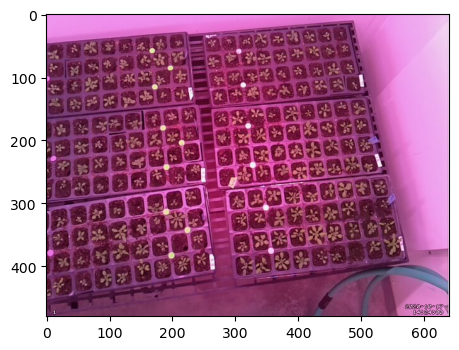

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


In [4]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass


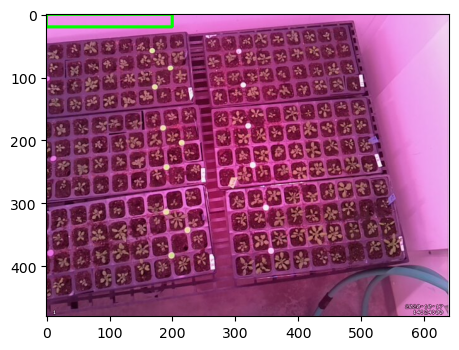

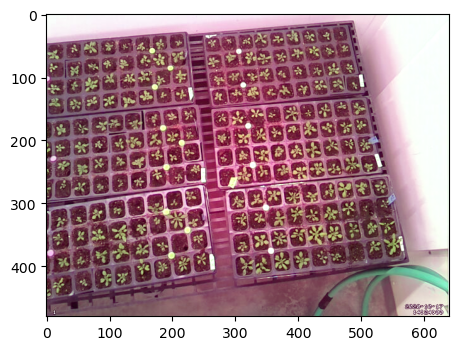

In [5]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(0,0,200,20))


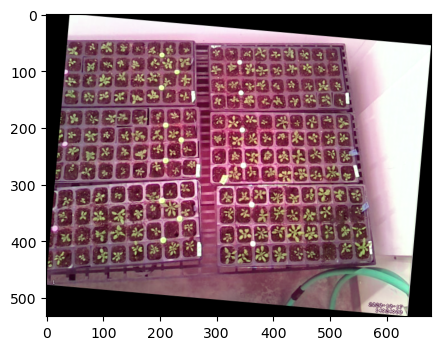

In [6]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
rotate_img = pcv.rotate(img=img1, rotation_deg=-5, crop=False)
img1=rotate_img

In [7]:
# Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.

# Inputs:
#   img    = image object
#   number = integer, number of pixels to move image
#   side   = direction to move from "top", "bottom", "right","left"
#shift1 = pcv.shift_img(img=img1, number=40, side='top')
#img1 = shift1


In [8]:
# Optionally, one could use the `pcv.flip` function that flips an image in either the 
# horizontal or vertical direction

# Inputs:
#   img   = RGB or grayscale image data 
#   direction = The direction you want the image flipped, either 'horizontal' or 'vertical' 
#flipped_img = pcv.flip(img=img, direction='vertical')


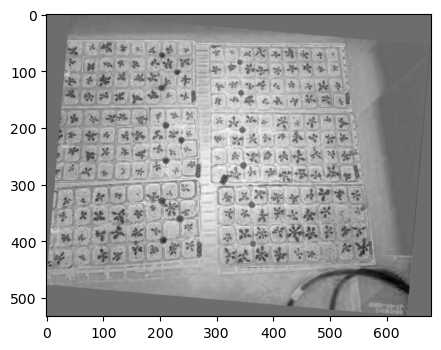

In [9]:
# Convert image from RGB color space to LAB color space
# Keep only the green-magenta channel (grayscale)

# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)
a = pcv.rgb2gray_lab(rgb_img=img1, channel='a')


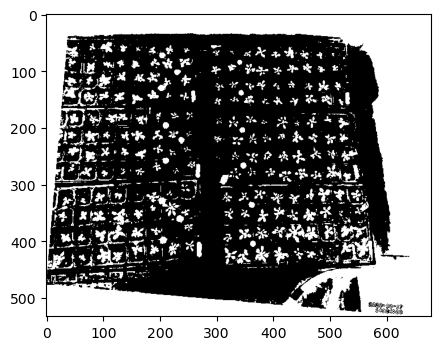

In [10]:
# Set a binary threshold on the saturation channel image

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done
img_binary = pcv.threshold.binary(gray_img=a, threshold=140, max_value=255, object_type='dark')
#                                                        ^
#                                                        |
#                                         adjust this value


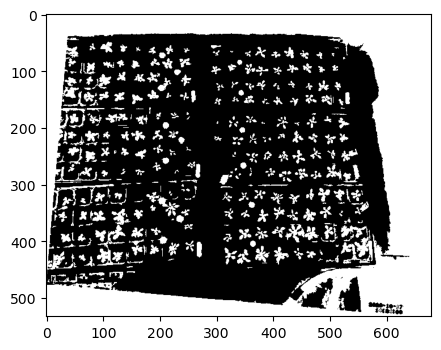

In [11]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=img_binary, size=10)
#                                                ^
#                                                |
#                                 adjust this value


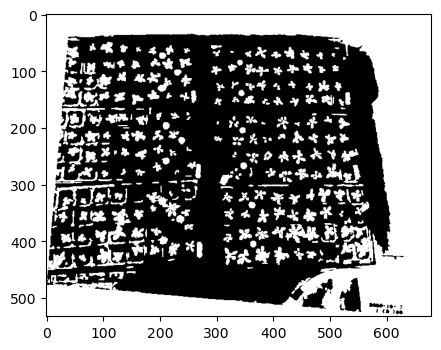

In [12]:
# Dilate so that you don't lose leaves (just in case)

# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=2, i=1)


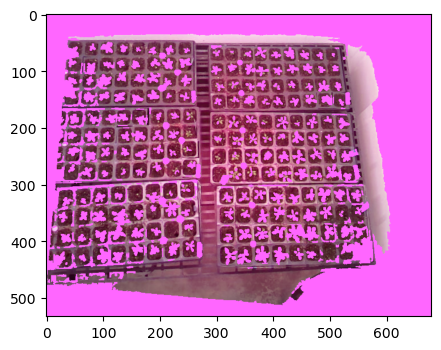

In [13]:
# Find objects (contours: black-white boundaries)

# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated)


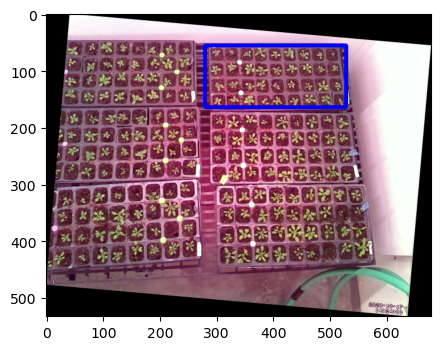

In [14]:
# Define region of interest (ROI)

# Inputs:
#    img   = An RGB or grayscale image to plot the ROI on.
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    h     = The width of the rectangle.
#    w     = The height of the rectangle.
#   roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1) 
#                                                  |______________|
#                                            adjust these four values
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=280, y=55, h=110, w=250)


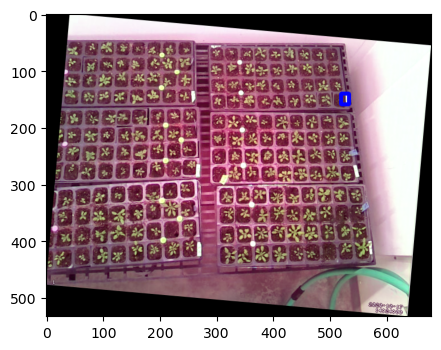

In [15]:
# (Optional): Get the size of the marker. First make a region of interest around one of 
# the toughspots. Then use `report_size_marker_area`. 
marker_contour, marker_hierarchy = pcv.roi.rectangle(img=img1, x=520, y=140, h=20, w=15)



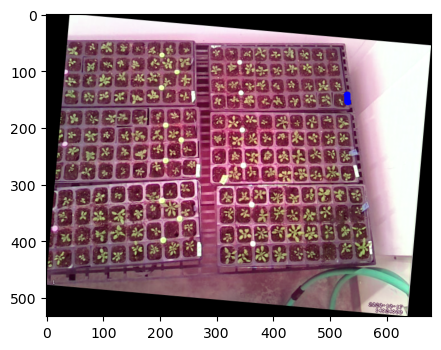

In [16]:
# Inputs:
#   img - RGB or grayscale image to plot the marker object on 
#   roi_contour = A region of interest contour 
#   roi_hierarchy = A region of interest contour heirarchy 
#   marker = 'define' (default) or 'detect', if 'define' then you set an area, if 'detect'
#            it means you want to detect within an area 
#   objcolor = Object color is 'dark' (default) or 'light', is the marker darker or lighter than 
#               the background?
#   thresh_channel = 'h', 's', 'v' for hue, saturation, or value. Default set to None. 
#   thresh = Binary threshold value (integer), default set to None 
analysis_images = pcv.report_size_marker_area(img=img1, roi_contour=marker_contour, 
                                              roi_hierarchy=marker_hierarchy, marker='detect', 
                                              objcolor='light', thresh_channel='v', thresh=230)


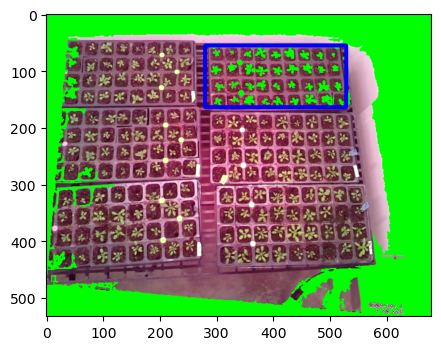

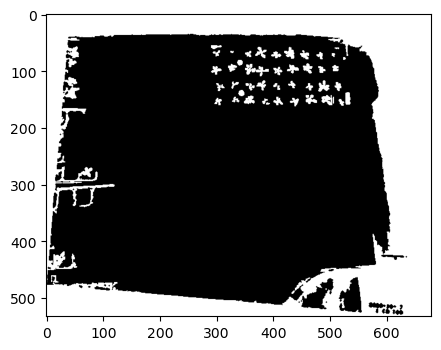

In [17]:
# Keep objects that overlap with the ROI

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')


In [18]:
# Check if all of the plants fall completely within the bounds of an image 
# or if it touches the edge. Used for QC. 

# Inputs:
#   mask = Binary mask 
in_bounds = pcv.within_frame(mask=kept_mask)


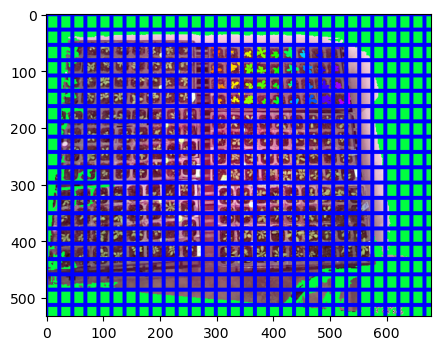

In [19]:
# This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=20, ncol=29, 
                                                         show_grid=True)


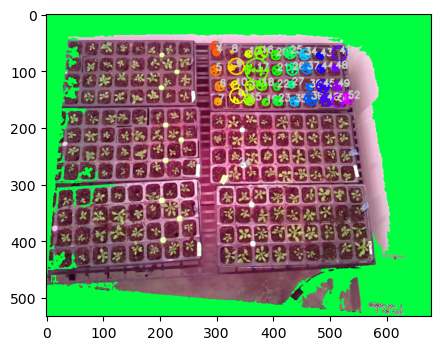

In [20]:
# OPTIONAL: For debugging or for making figures 

# The image is relatively small, decrease the global line thickness parameter 
pcv.params.line_thickness = 2

# Plot to visualize what pieces of plant got grouped together.

# Inputs:
#   img - RGB or grayscale image data for plotting
#   grouped_contour_indices - Indices for grouping contours
#   roi_objects - object contours in an image that are needed to be clustered.
#   roi_obj_hierarchy - object hierarchy
#   nrow - Optional, number of rows. If changed from default, grid gets plot. 
#   ncol - Optional, number of columns. If changed from default, grid gets plot. 
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)


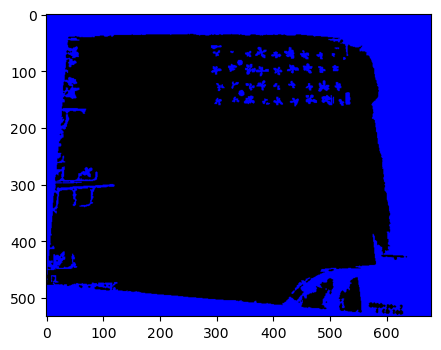

In [21]:
# Segment objects into spatial based clusters within an image

import os
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from plantcv.plantcv import params
from plantcv.plantcv import print_image
from plantcv.plantcv import plot_image
from plantcv.plantcv import color_palette


def spatial_clustering (mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=None):
    """Counts and segments portions of an image based on distance between two pixels.
    Masks showing all clusters, plus masks of individual clusters, are returned.
    Inputs:
    mask             = Mask/binary image to segment into clusters.
    algorithm        = Algorithm to use for segregating different clusters.
                       Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
    min_cluster_size = The minimum size a section of a mask must be (in pixels)
                       before it can be considered its own cluster. (Default=5)
    max_distance     = The total distance between two pixels for them to be considered a part
                       of the same cluster.  For the DBSCAN algorithm, value must be between
                       0 and 1.  For OPTICS, the value is in pixels and depends on the size
                       of your picture.  (Default=0)
    Returns:
    clust_img        = Output image with each cluster draw with a unique color.
    clust_masks      = List of binary masks, one per cluster.
    :param mask: numpy.ndarray
    :param algorithm: str
    :param min_cluster_size: int
    :param max_distance: float
    :return clust_img: numpy.ndarray
    :return clust_masks: list
    """

    # Increment device counter
    params.device += 1

    # Uppercase algorithm name
    al_upper = algorithm.upper()

    # Dictionary of default values per algorithm
    default_max_dist = {"DBSCAN": 0.2, "OPTICS": np.inf}

    # If the algorithm is not in the default_max_dist dictionary raise a NameError
    if al_upper not in default_max_dist:
        raise NameError("Please use only 'OPTICS' or 'DBSCAN' ")

    # If max_distance is not set, apply the default value
    if max_distance is None:
        max_distance = default_max_dist.get(al_upper)

    # Get all x, y coordinates of white pixels in the mask
    x, y = np.where(mask == 255)
    zipped = np.column_stack((x, y))

    if "OPTICS" in al_upper:
        scaled = StandardScaler(with_mean=False, with_std=False).fit_transform(zipped)
        db = OPTICS(max_eps=max_distance, min_samples=min_cluster_size, n_jobs=-1).fit(scaled)
    elif "DBSCAN" in al_upper:
        scaled = StandardScaler().fit_transform(zipped)
        db = DBSCAN(eps=max_distance, min_samples=min_cluster_size, n_jobs=-1).fit(scaled)

    # Number of clusters
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    # Create a color palette of n_clusters colors
    colors = color_palette(n_clusters + 1)
    # Initialize variables
    dict_of_colors = {}
    clust_masks = []
    h, w = mask.shape
    # Colorized clusters image
    clust_img = np.zeros((h, w, 3), np.uint8)
    # Index the label color for each cluster
    for y in range(0, n_clusters):
        dict_of_colors[str(y)] = colors[y]
        clust_masks.append(np.zeros((h, w), np.uint8))

    # Group -1 are points not assigned to a cluster
    dict_of_colors["-1"] = (255, 255, 255)

    # Loop over labels/clusters
    for z in range(0, len(db.labels_)):
        if not db.labels_[z] == -1:
            # Create a binary mask for each cluster
            clust_masks[db.labels_[z]][zipped[z][0], zipped[z][1]] = 255

        # Add a cluster with a unique label color to the cluster image
        clust_img[zipped[z][0], zipped[z][1]] = (dict_of_colors[str(db.labels_[z])][2],
                                                 dict_of_colors[str(db.labels_[z])][1],
                                                 dict_of_colors[str(db.labels_[z])][0])

    if params.debug == 'print':
        print_image(clust_img, os.path.join(params.debug_outdir, f"{params.device}_{al_upper}_clusters.png"))

    elif params.debug == 'plot':
        plot_image(clust_img)

    return clust_img, clust_masks

# Inputs:
# mask             = Mask/binary image to segment into clusters.
# algorithm        = Algorithm to use for segregating different clusters.
#                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
# min_cluster_size = The minimum size a section of a mask must be (in pixels)
#                    before it can be considered its own cluster. (Default=5)
# max_distance     = The total distance between two pixels for them to be considered a part
#                    of the same cluster.  For the DBSCAN algorithm, value must be between
#                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
#                    of your picture.  (Default=0)
clust_img, clust_masks = spatial_clustering(mask=kept_mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=None)


In [22]:
# Inputs:
# mask             = Mask/binary image to segment into clusters.
# algorithm        = Algorithm to use for segregating different clusters.
#                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN")
# min_cluster_size = The minimum size a section of a mask must be (in pixels)
#                    before it can be considered its own cluster. (Default=5)
# max_distance     = The total distance between two pixels for them to be considered a part
#                    of the same cluster.  For the DBSCAN algorithm, value must be between
#                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
#                    of your picture.  (Default=0)
#clust_img, clust_masks = pcv.spatial_clustering(mask=kept_mask, algorithm="DBSCAN", min_cluster_size=5, max_distance=None)


In [23]:
# The pcv.cluster_contours function uses another PlantCV function
# that returns a random list of RGB color values equally spaces
# across a rainbow color spectrum. This function can be useful 
# when a color palette is needed 

# Inputs:
#   num - An integer greater than or equal to 1. If num=1 then 
#         a random color is returned 
rand_colors = pcv.color_palette(num=5)
print(rand_colors)


[(0, 0, 255), (0, 255, 205), (100, 255, 0), (255, 106, 0), (255, 0, 199)]


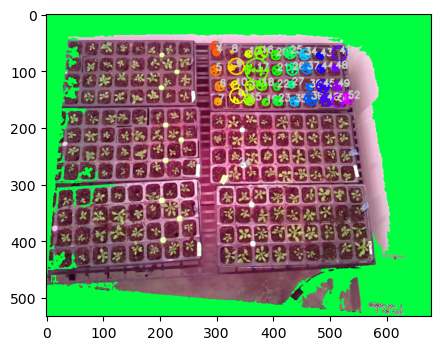

In [24]:
# Set the sequence of colors from the color_scale created by the 
# color_palette function to "sequential" or "random" order. 
# Default = "sequential". 
pcv.params.color_sequence = 'random'
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)

This function has been updated to include object hierarchy so object holes can be included


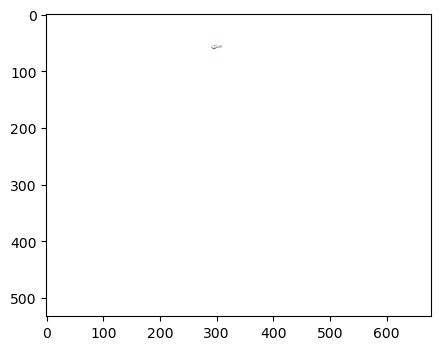

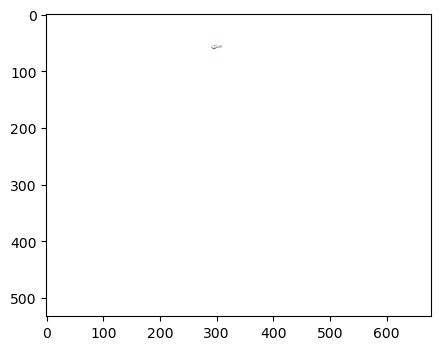

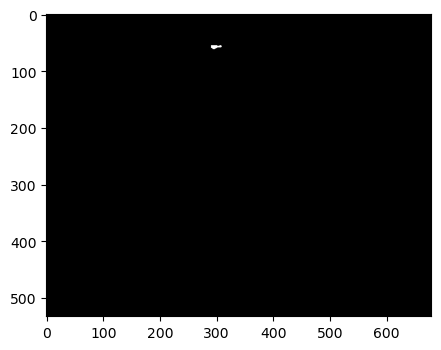

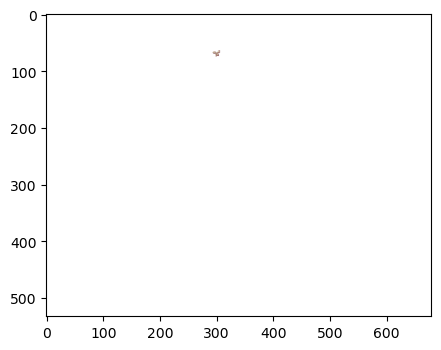

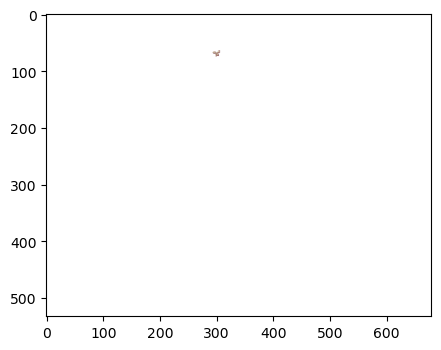

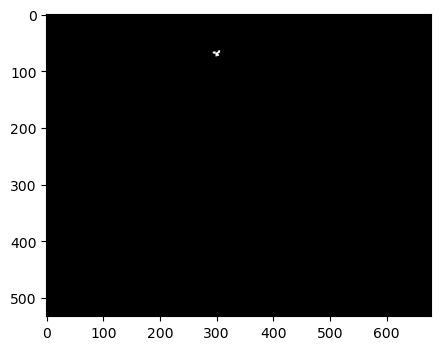

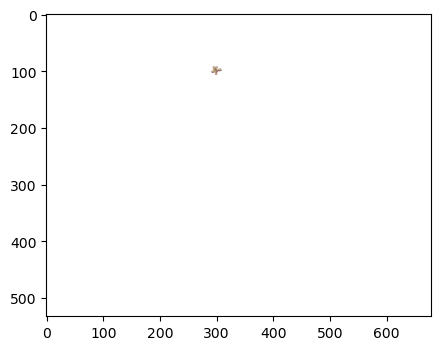

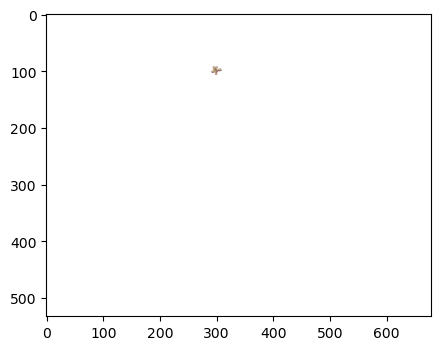

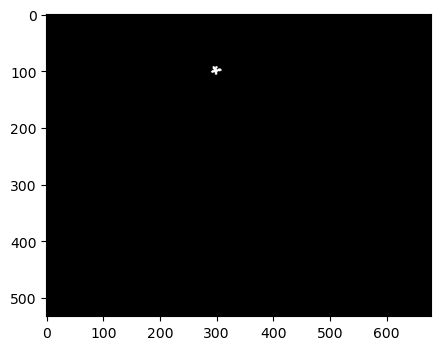

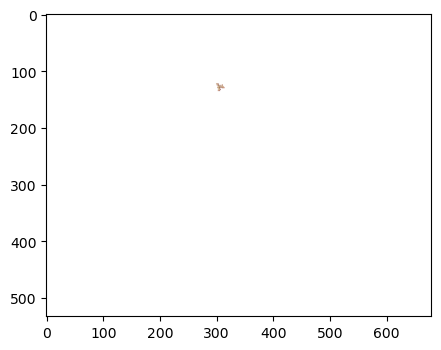

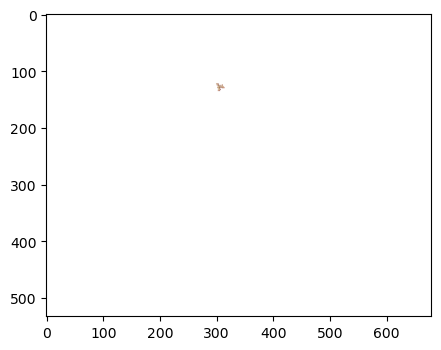

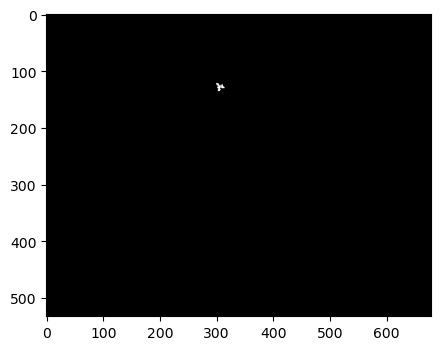

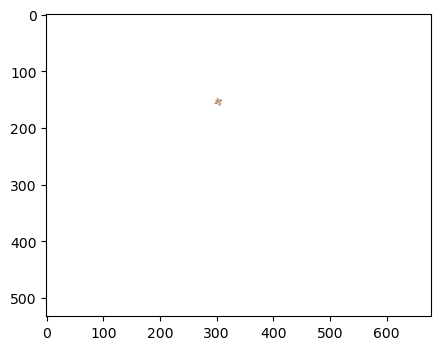

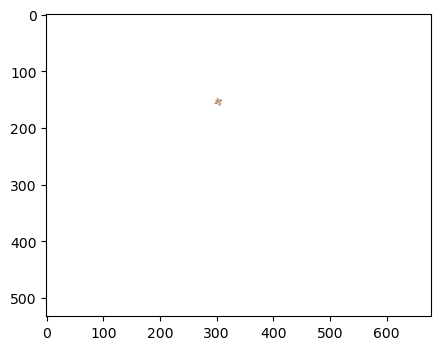

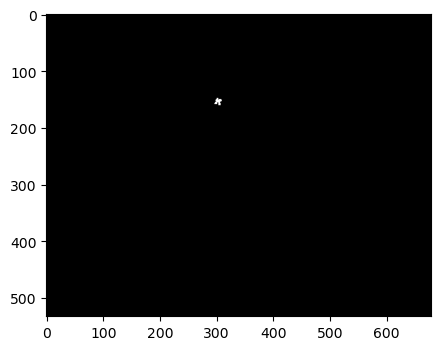

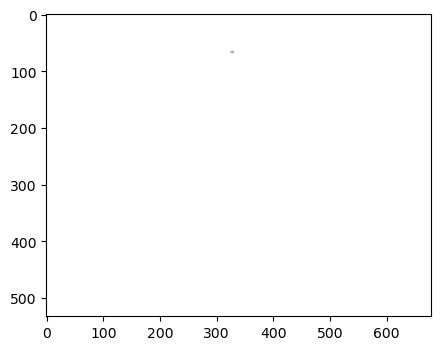

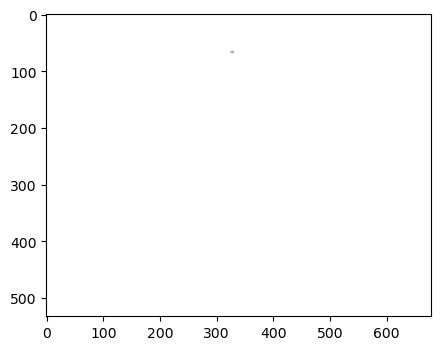

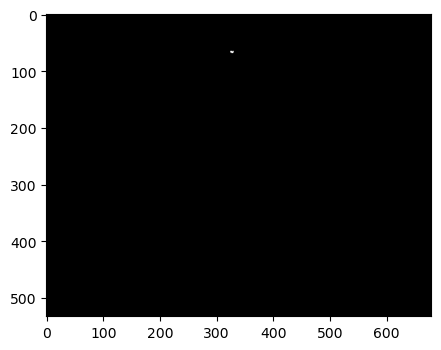

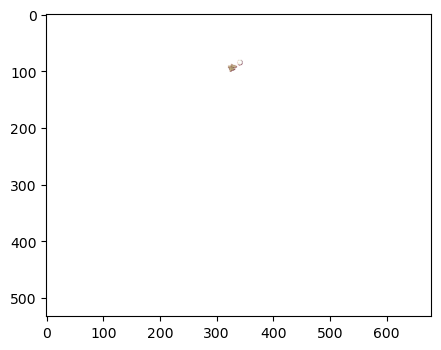

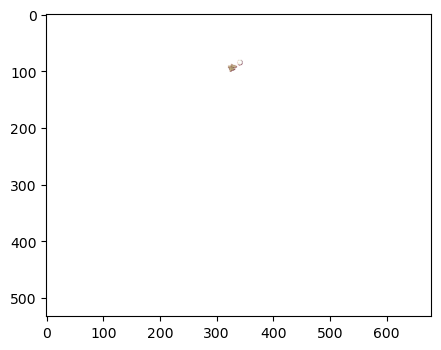

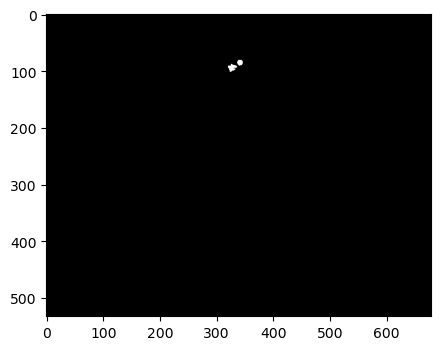

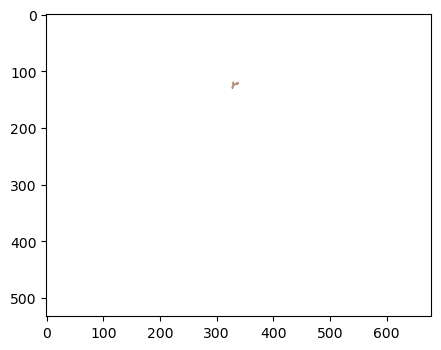

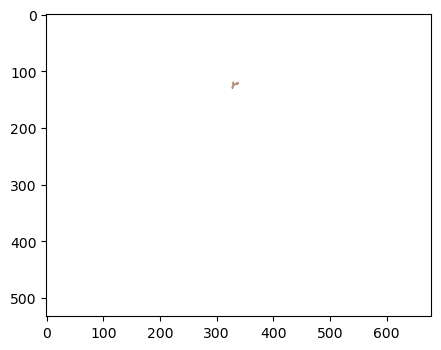

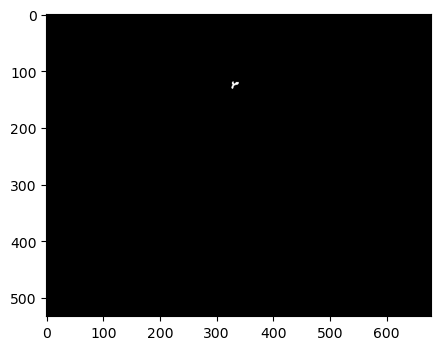

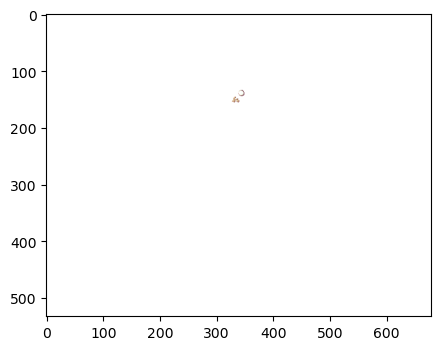

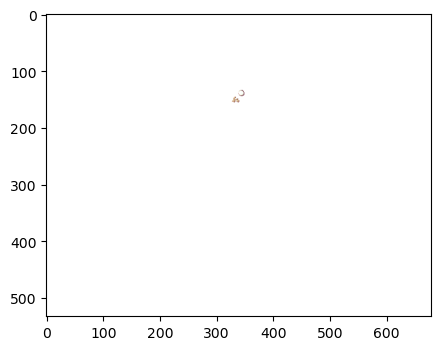

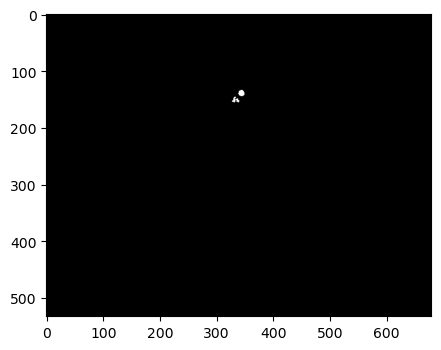

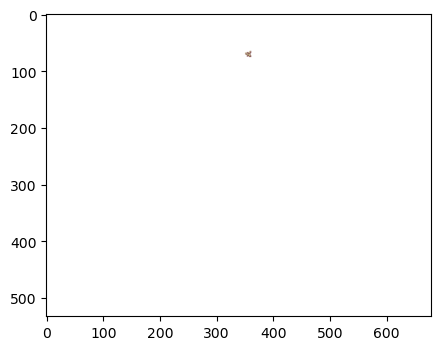

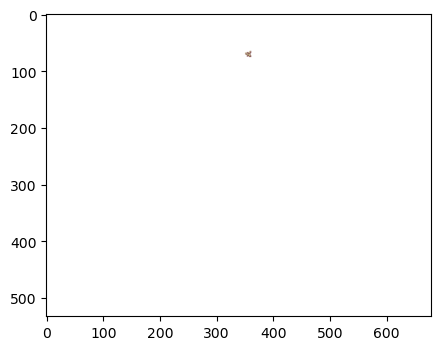

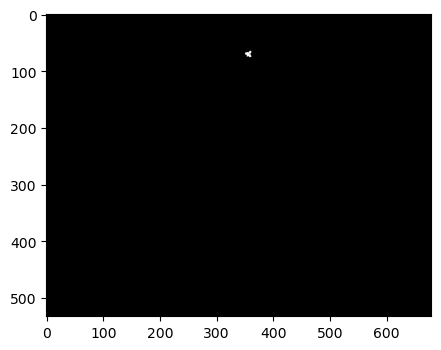

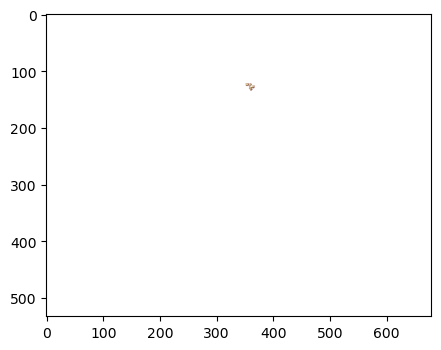

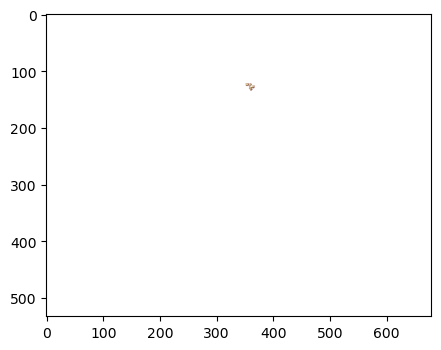

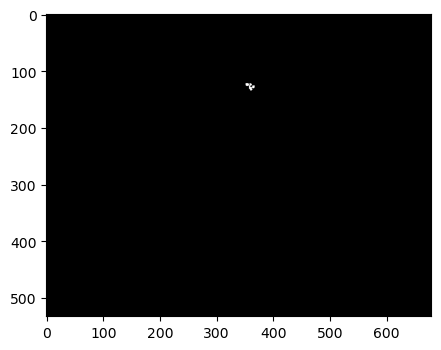

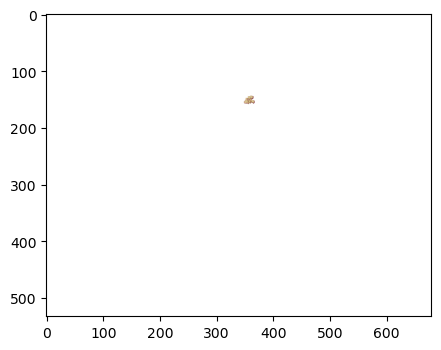

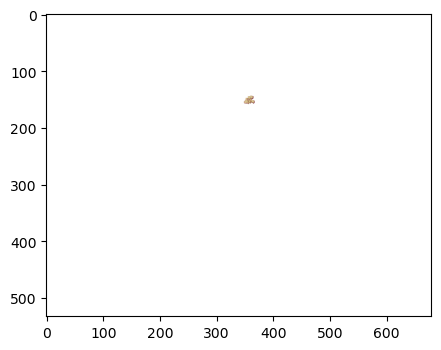

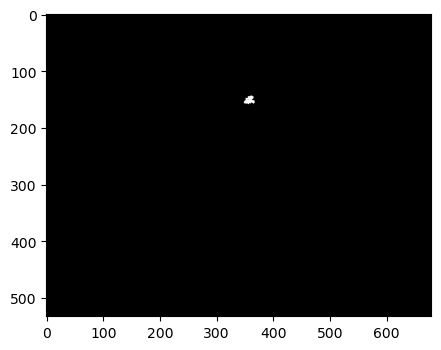

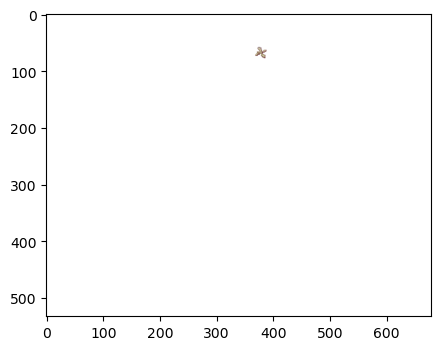

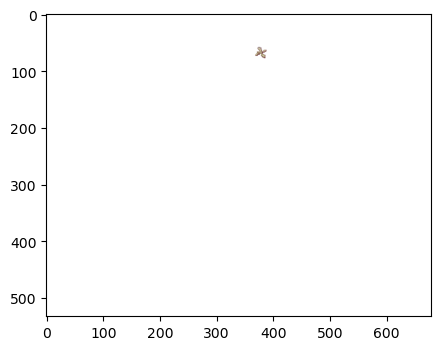

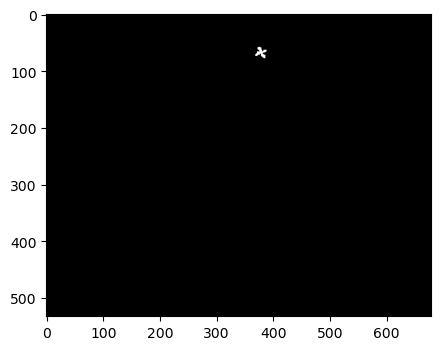

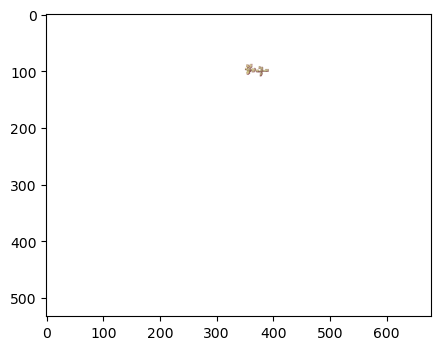

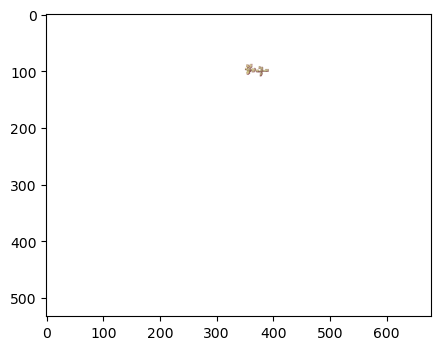

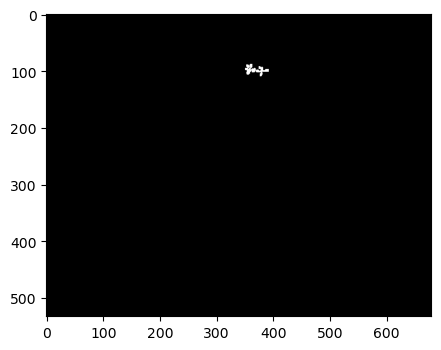

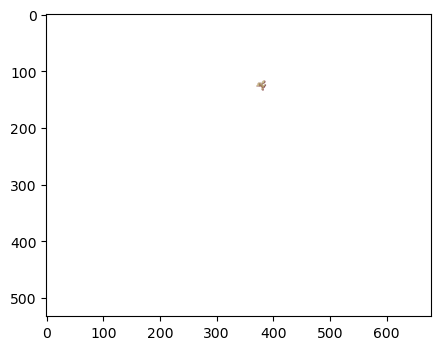

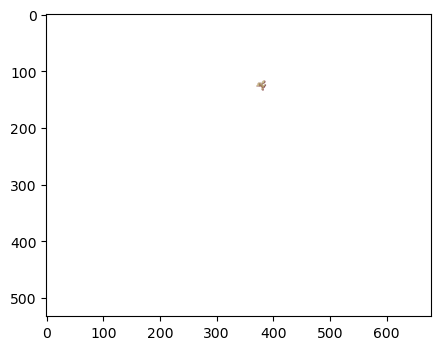

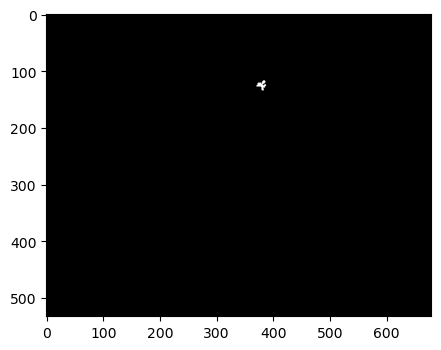

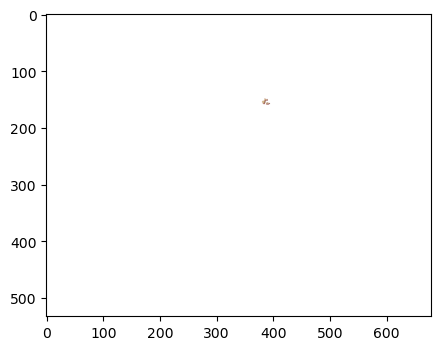

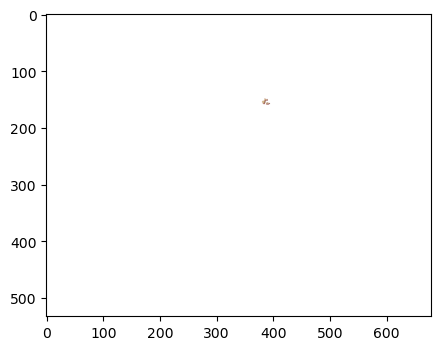

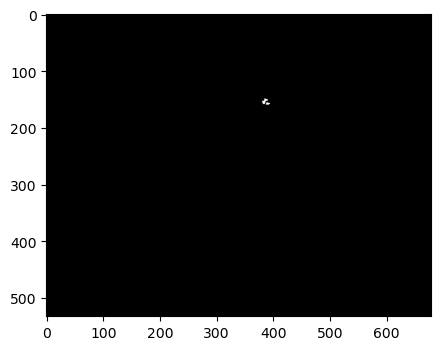

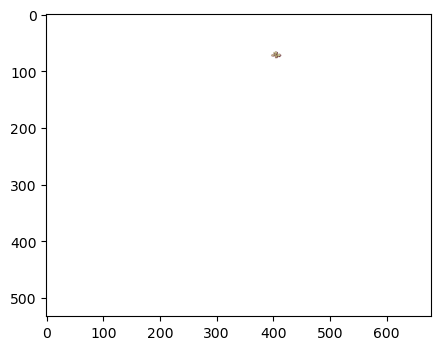

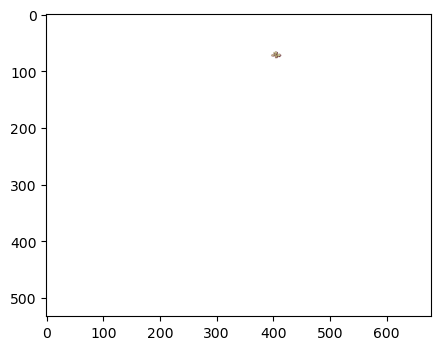

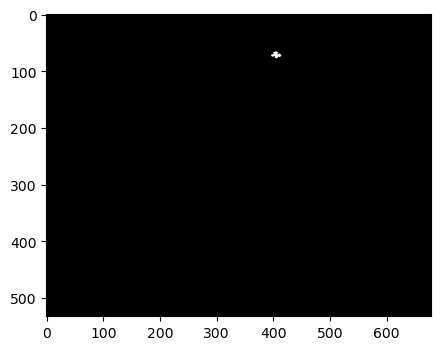

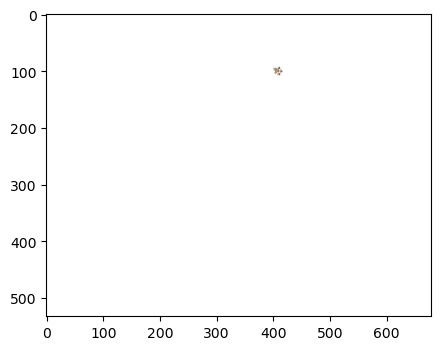

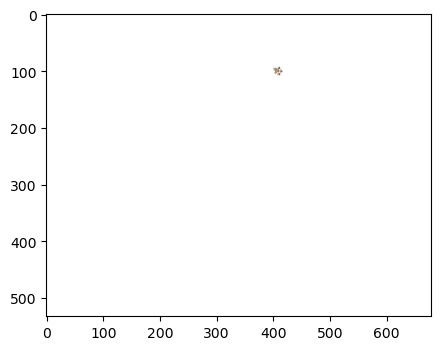

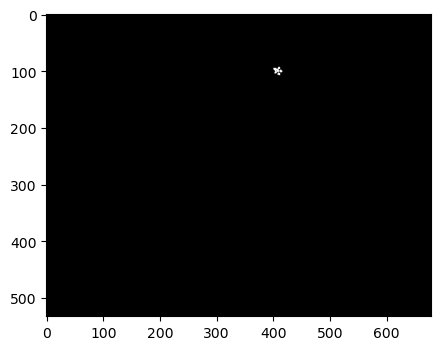

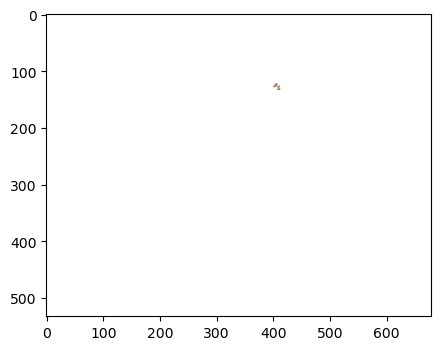

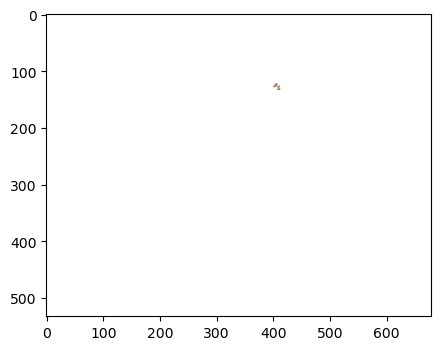

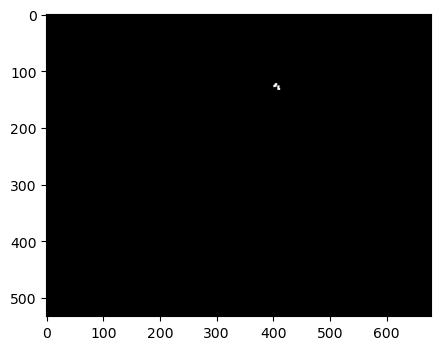

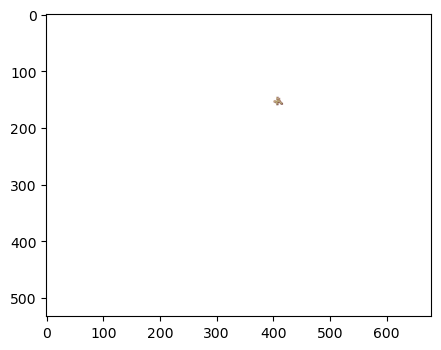

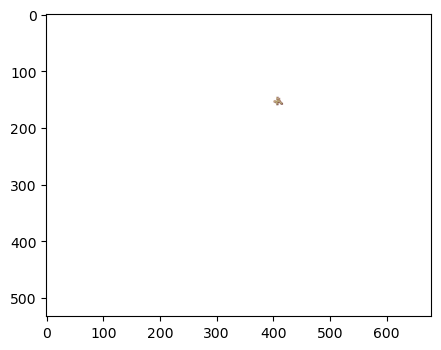

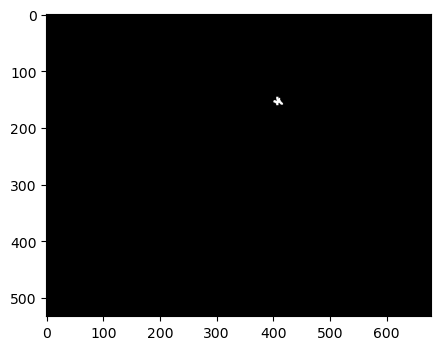

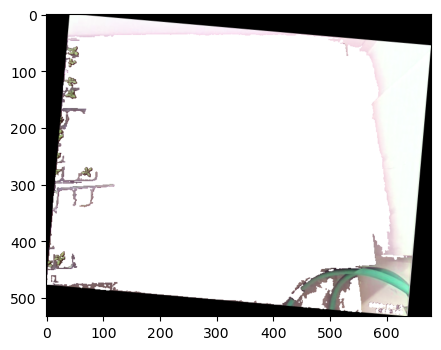

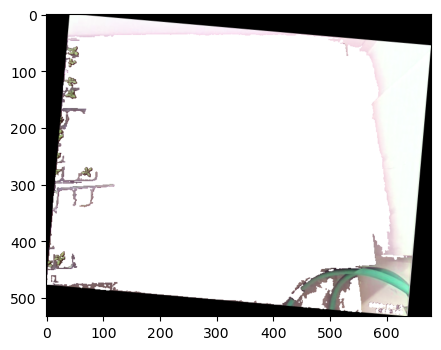

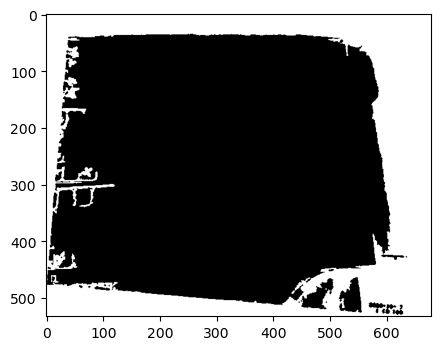

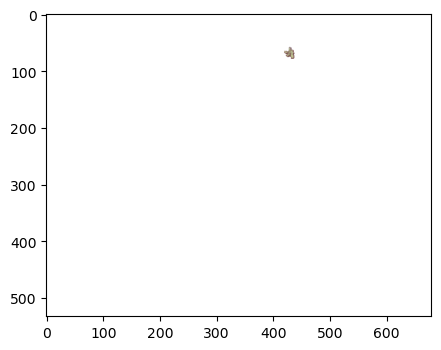

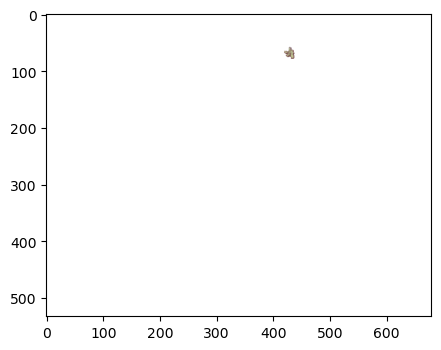

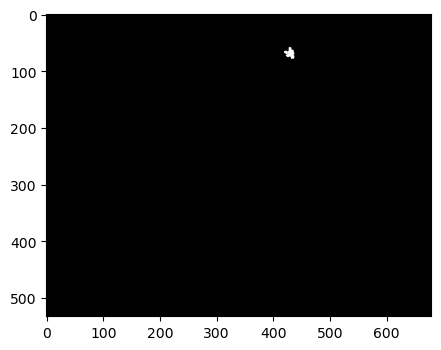

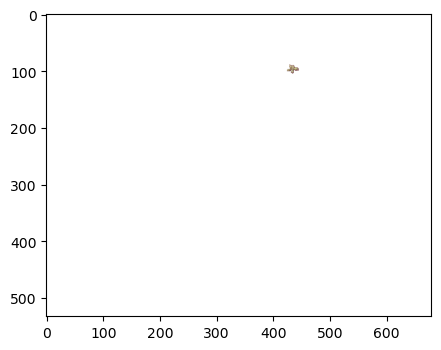

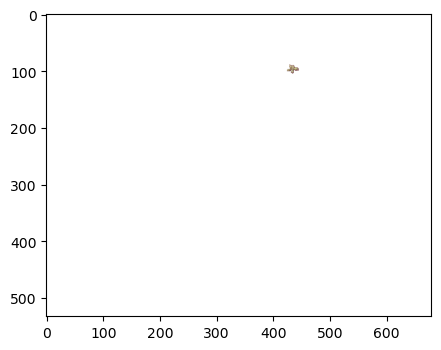

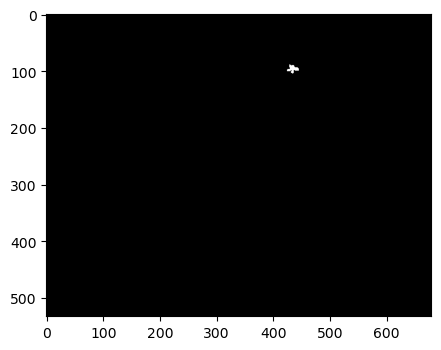

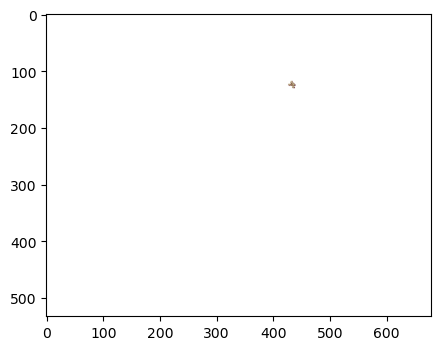

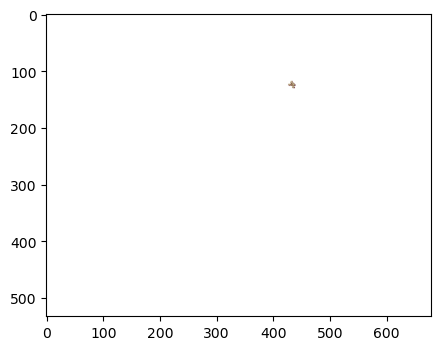

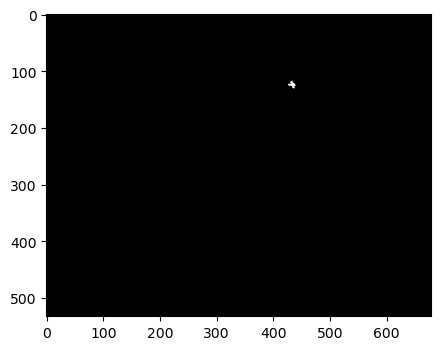

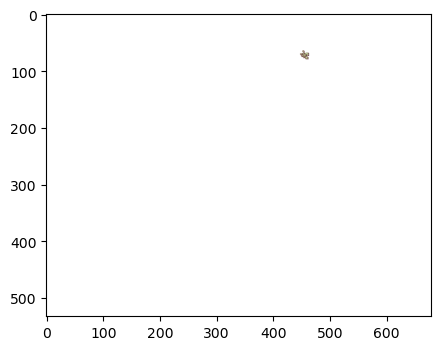

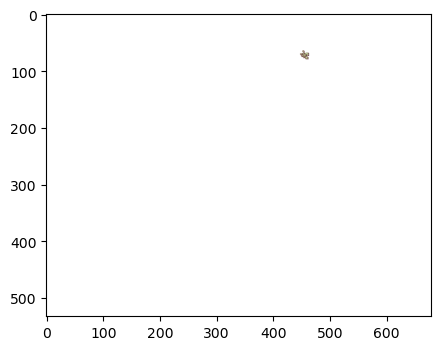

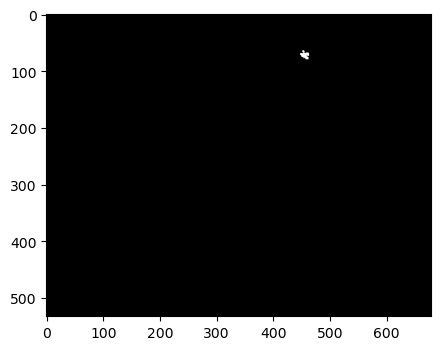

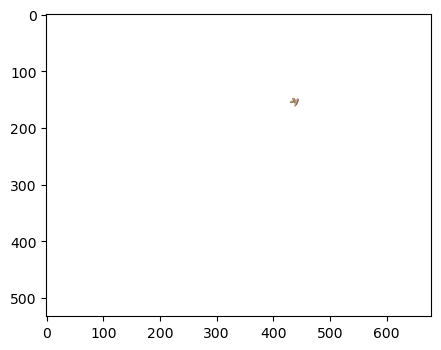

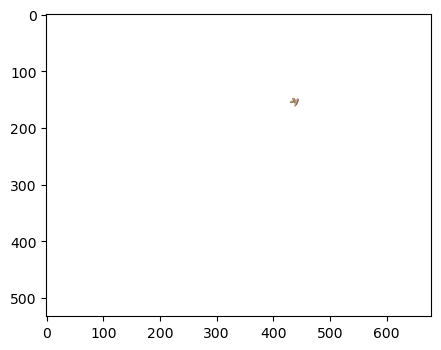

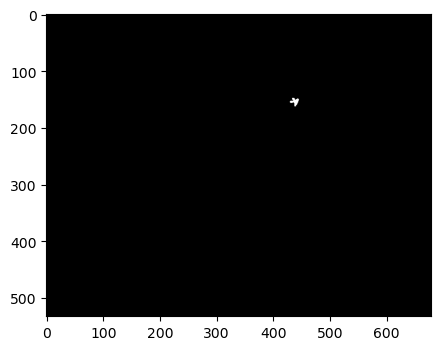

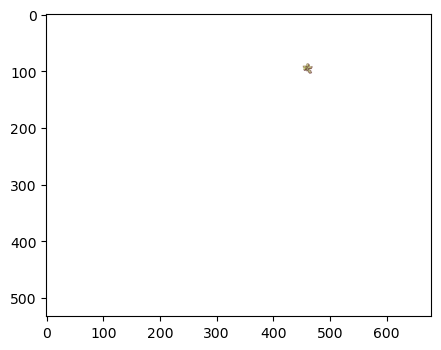

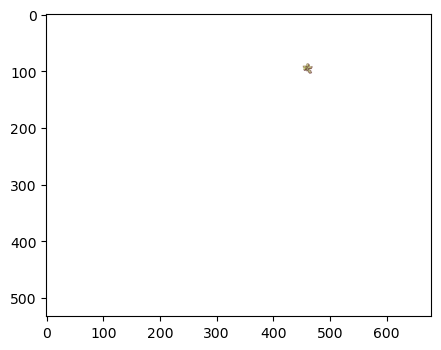

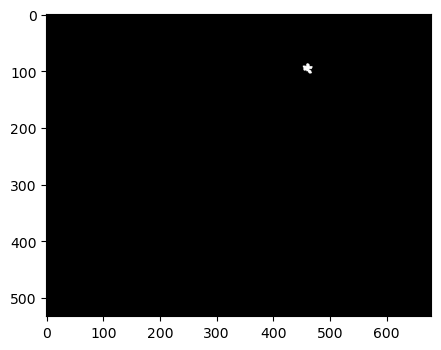

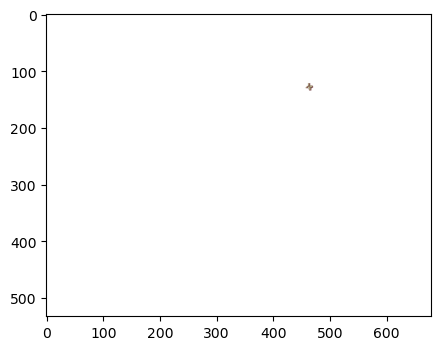

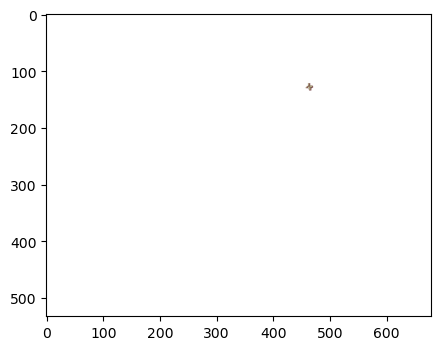

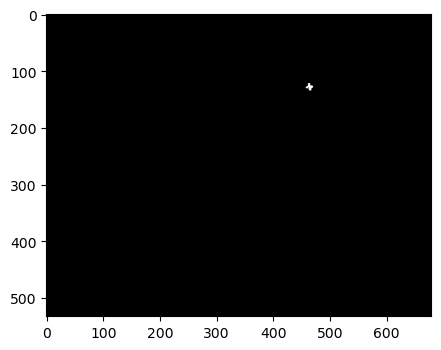

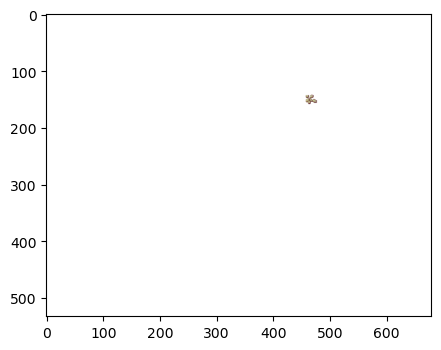

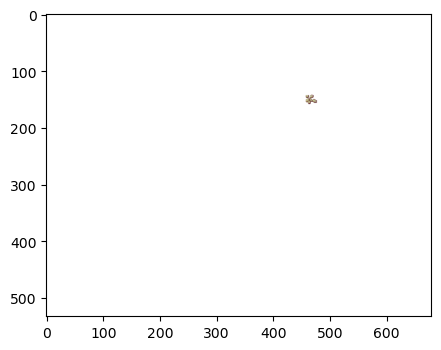

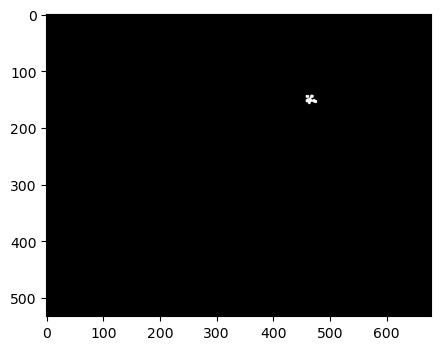

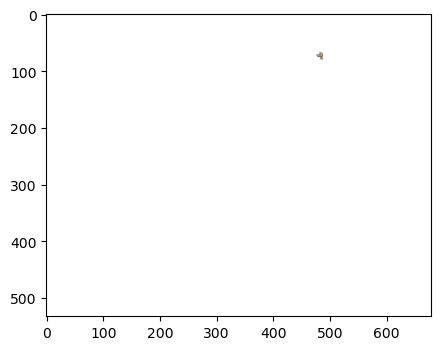

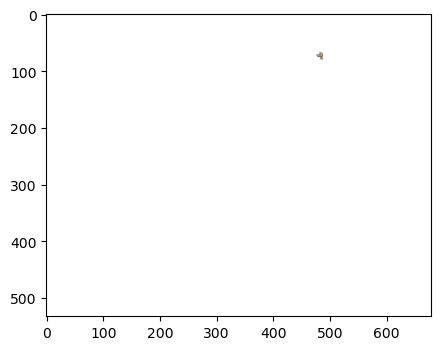

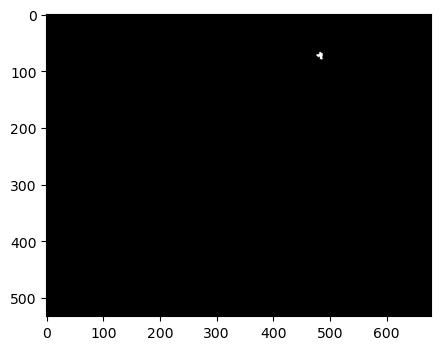

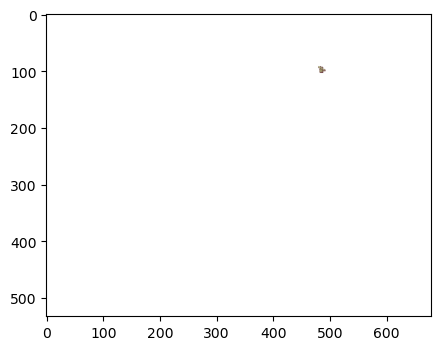

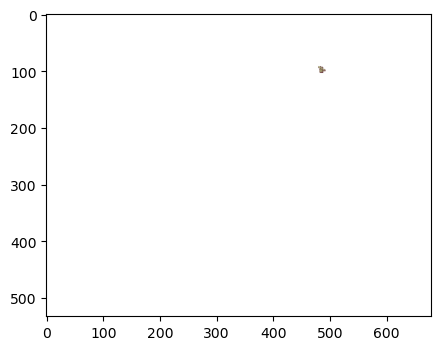

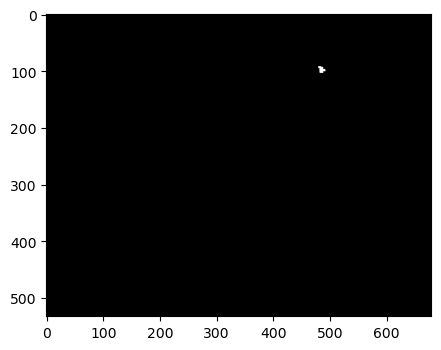

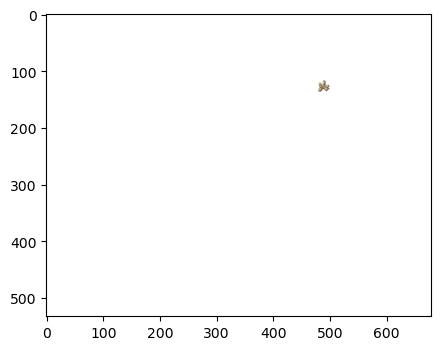

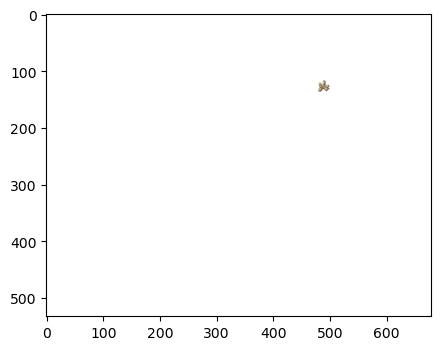

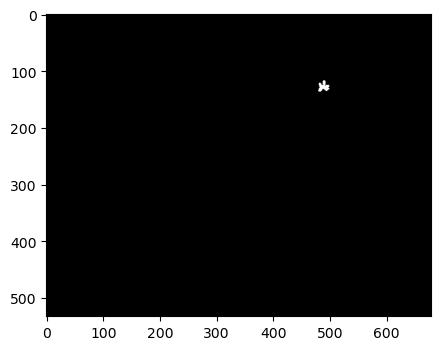

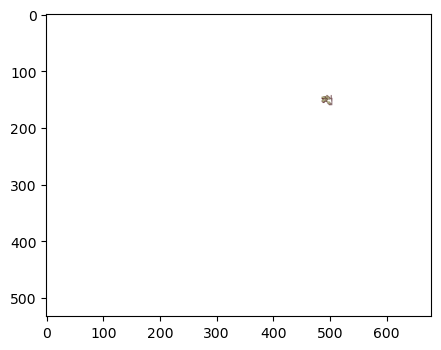

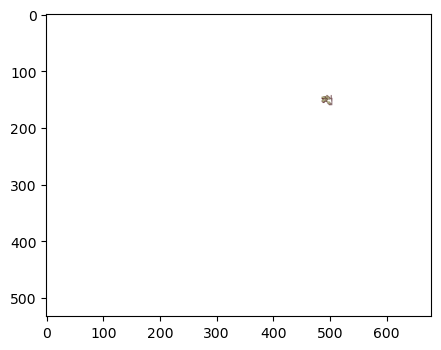

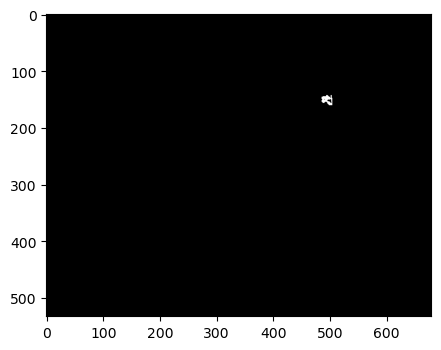

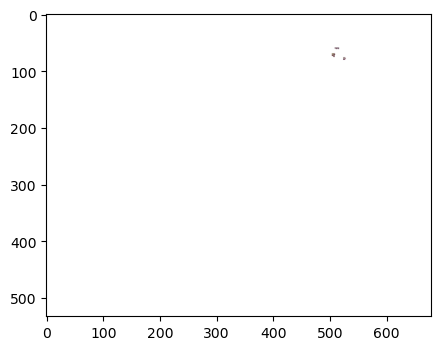

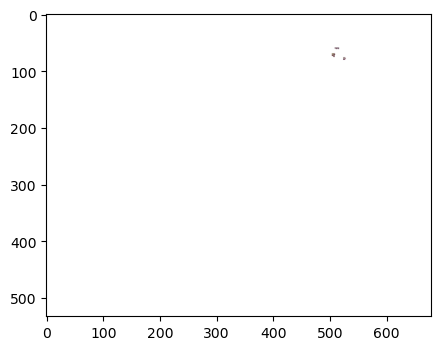

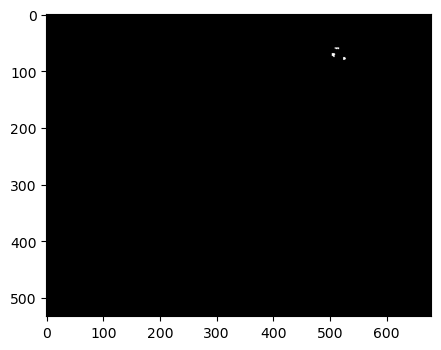

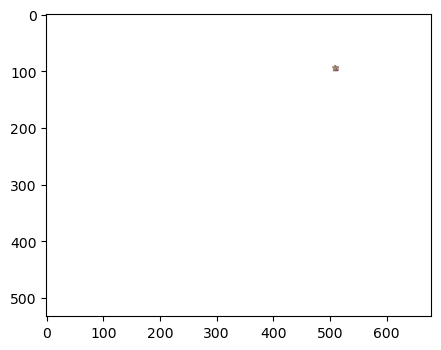

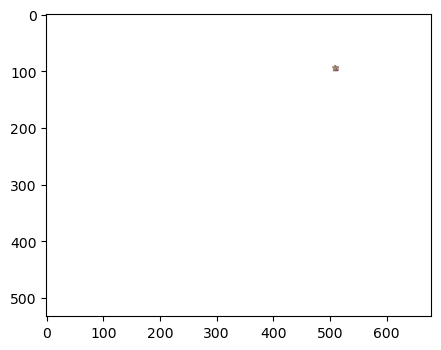

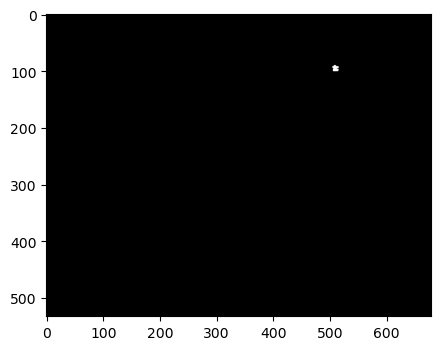

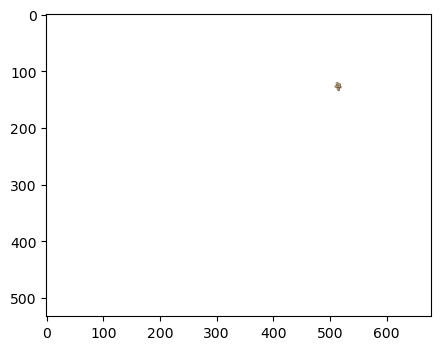

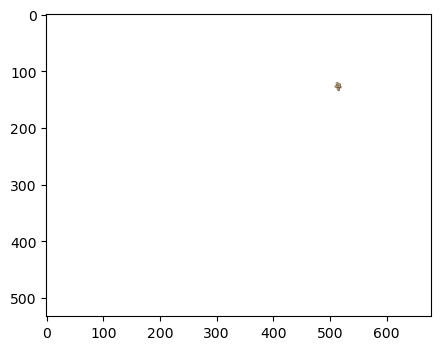

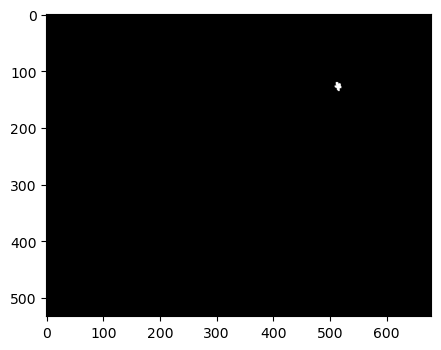

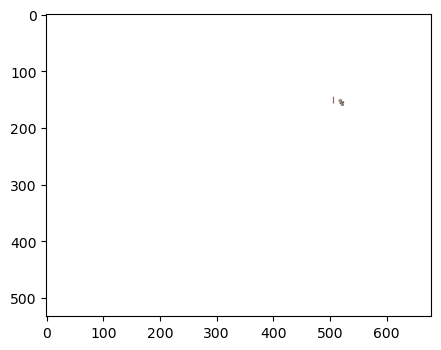

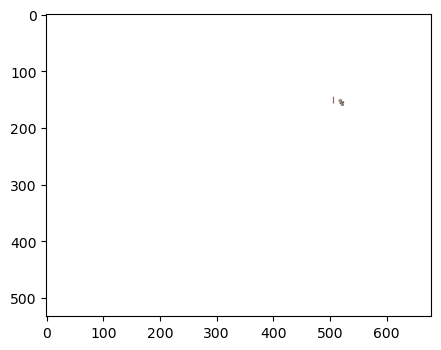

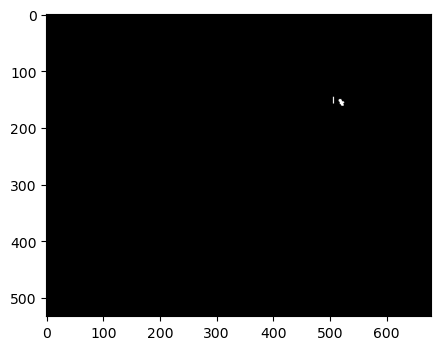

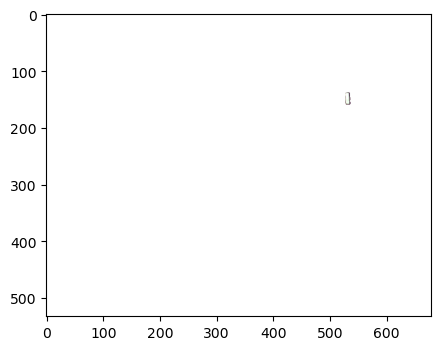

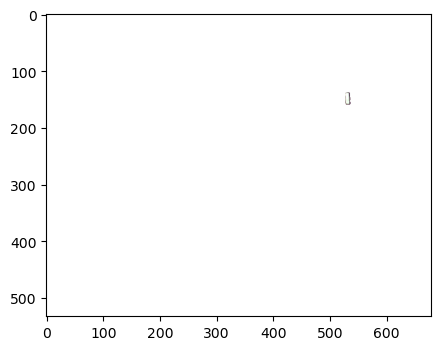

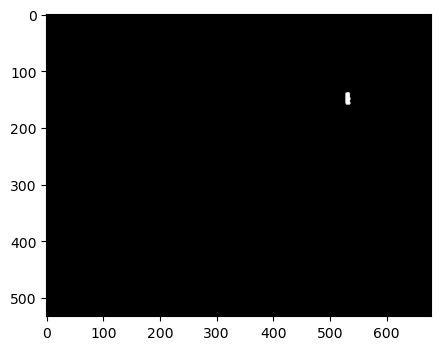

In [26]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "plot"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
output_path = pcv.cluster_contour_splitimg(rgb_img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)


There is a PlantCV function is based on code contributed by Suxing Liu, Arkansas State University.
For more information see [https://github.com/lsx1980/Leaf_count](https://github.com/lsx1980/Leaf_count).
This function uses the watershed algorithm to detect boundary of objects.
Needs a mask file which specifies area which is object is white, and background is black.
Requires cv2 version 3.0+

In [99]:
# Read in one of the isolated plant images 
#pcv.params.debug = args.debug

#single_plant, plant_path, plant_filename = pcv.readimage(filename='14-24-00_49_p49.png')


In [31]:
# Another option is to use multi_roi

# Create multiple ROIs on the same image:  
# Used to define multiple regions of interest in the same image. Users can either specify a
# starting coordinate (`coord`), number of rowsand columns, and spacing to create a grid of ROIs,
# or a custom list of coordinates that specify the centers of the ROIs. Providing a custom list 
# of coordinates (list of tuples) is useful for missing plants or any arrangement that isn't 
# a perfect grid. Returns lists of contours and hierarchies that can be used in downstream steps. 

#     Inputs
#     img            = Input image data.
#     coord          = Two-element tuple of the center of the top left object.
#     radius         = Radius of ROIs.
#     spacing        = Two-element tuple of the horizontal and vertical spacing between ROIs.
#     nrows          = Number of rows in ROI layout.
#     ncols          = Number of columns in ROI layout.

# Make a grid of ROIs 
rois1, roi_hierarchy1 = pcv.roi.multi(img=img1, coord=(25,120), radius=20, spacing=(70, 70), nrows=3, ncols=6)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# The image is relatively small so decrease line_thickness parameter (default = 5)
pcv.params.line_thickness = 2

# Specify a list of coordinates of desired ROIs 
rois2, roi_hierarchy2 = pcv.roi.multi(img=img1, coord=[(25,120), (165,260), (310, 260)], radius=20)


In [ ]:
import numpy as np 

img_copy = np.copy(img1)

# Analyze each plant using the ROI's created by using the grid setup for pcv.roi.multi

for i in range(0, len(rois1)):
    roi = rois1[i]
    hierarchy = roi_hierarchy1[i]
    # Filter objects by ROI 
    filtered_contours, filtered_hierarchy, filtered_mask, filtered_area = pcv.roi_objects(
        img=img1, roi_type="partial", roi_contour=roi, roi_hierarchy=hierarchy, object_contour=roi_objects, 
        obj_hierarchy=roi_obj_hierarchy)

    # Combine objects together in each plant     
    plant_contour, plant_mask = pcv.object_composition(img=img_copy, contours=filtered_contours, hierarchy=filtered_hierarchy)        

    # Analyze the shape of each plant 
    analysis_images = pcv.analyze_object(img=img_copy, obj=plant_contour, mask=plant_mask)

    # Save the image with shape characteristics 
    img_copy = analysis_images

    # Print out a text file with shape data for each plant in the image 
    pcv.print_results(filename = 'prefix_' + str(i) + '.txt')
    # Clear the measurements stored globally into the Ouptuts class
    pcv.outputs.clear()

# Plot out the image with shape analysis on each plant in the image 
pcv.plot_image(img_copy)



To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the multi-plant text files 

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 


